<a href="https://colab.research.google.com/github/dhruvRajoria/Orbit_Forecast/blob/main/Orbit_Forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import plotly.express as px  # For interactive plots
import datetime
import warnings

In [189]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

**Step 1**

In [190]:
# --- Step 1: Load the space object dataset ---
space_data = pd.read_csv("/content/drive/MyDrive/Skyserver_SQL2_27_2018 6_51_39 PM.csv")


In [ ]:
# Preview the dataset
print(space_data.head())
space_data.shape

          objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598370  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   
3  1.237650e+18  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233   
4  1.237650e+18  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   
3  15.90438  752    301       4    269  3.722370e+18    STAR -0.000111   3306   
4  16.61326  752    301       4    269  3.722370e+18    STAR  0.000590   3306   

     mjd  fiberid  
0  549

(10000, 18)

In [191]:
# Check for missing values
print("Missing values in each column:\n", space_data.isnull().sum())

Missing values in each column:
 objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64


In [192]:
# Check the actual column names
print("Column Names:", space_data.columns.tolist())

Column Names: ['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid']


In [193]:
# Feature selection (ensure correct column names)
object_type_column = 'class'  # Assuming 'class' is the target for classification
orbital_parameters_column = 'redshift'  # Assuming 'redshift' is the target for regression
timestamp_column = 'mjd'  # Assuming 'mjd' represents the modified Julian date


In [194]:
# Create new features for future predictions
# Convert 'mjd' to datetime using a known reference point (January 1, 2000 corresponds to MJD 51544)
try:
    base_date = pd.to_datetime('2000-01-01')  # Base date for MJD conversion
    space_data[timestamp_column] = base_date + pd.to_timedelta(space_data[timestamp_column], unit='D')  # Convert MJD to datetime
except Exception as e:
    print(f"Error converting MJD to datetime: {e}")
    space_data[timestamp_column] = pd.NaT  # Fill with NaT for errors


In [195]:
# Ensure the conversion was successful
if space_data[timestamp_column].isnull().any():
    print("There are NaT values in the timestamp column due to conversion errors.")

In [196]:
# Extract date components
space_data['year'] = space_data[timestamp_column].dt.year
space_data['month'] = space_data[timestamp_column].dt.month
space_data['day'] = space_data[timestamp_column].dt.day


In [197]:
# Drop rows with NaN values after creating new features
space_data.dropna(inplace=True)


In [198]:
# Feature matrix (X) and target variables (y for regression, y_class for classification)
X = space_data.drop([object_type_column, orbital_parameters_column, timestamp_column], axis=1)  # Features
y_class = space_data[object_type_column]  # Classification target
y_reg = space_data[orbital_parameters_column]  # Regression target
space_data.shape

(10000, 21)

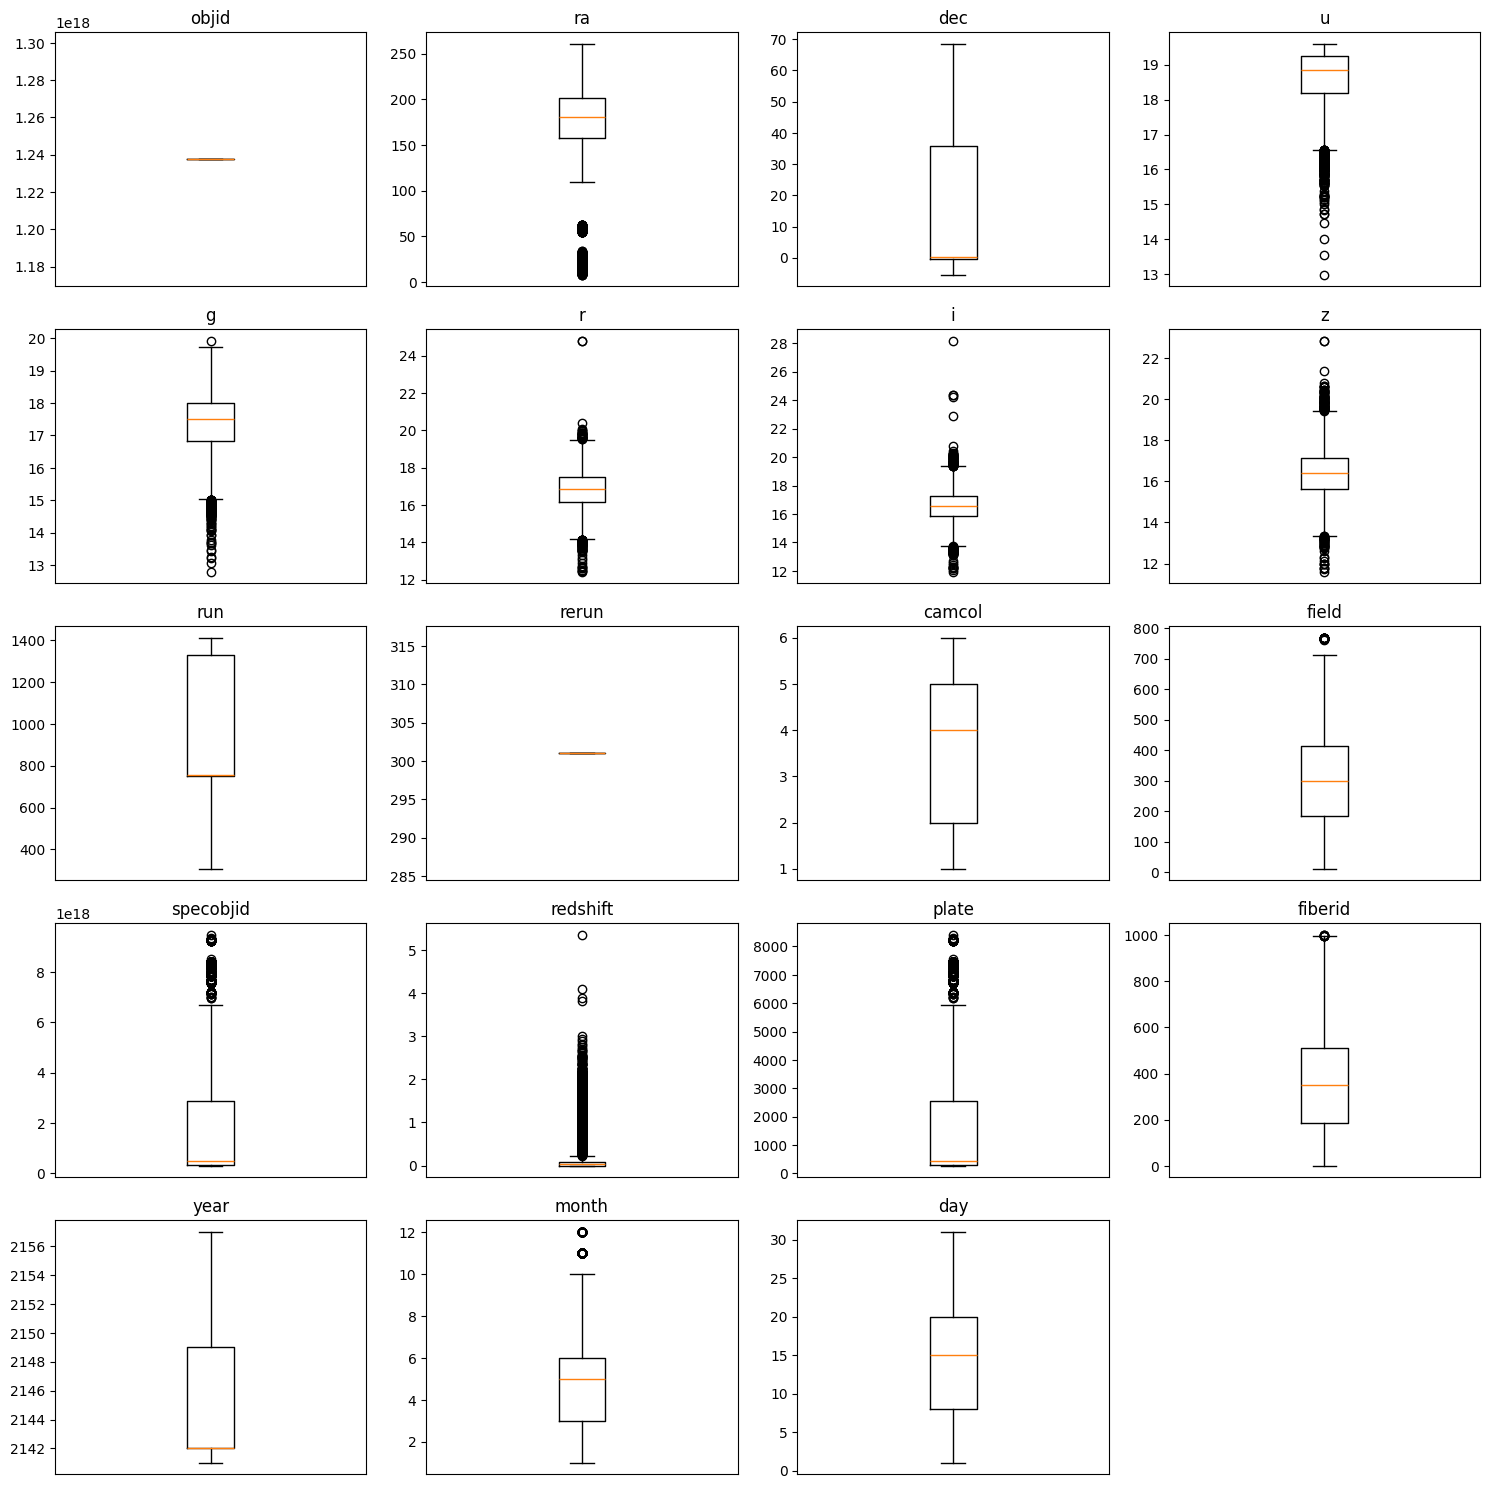

In [199]:
import pandas as pd
import matplotlib.pyplot as plt

# Select only numeric columns for outlier detection
numeric_columns = space_data.select_dtypes(include='number').columns

# Define the grid size based on the number of numeric columns
n_cols = 4  # Number of columns in the grid
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculate rows needed

# Set up the plotting area
plt.figure(figsize=(15, n_rows * 3))

# Loop through each numeric column to plot its boxplot
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(space_data [col].dropna())
    plt.title(col)
    plt.xticks([])  # Remove x-ticks for a cleaner look

plt.tight_layout()
plt.show()


In [200]:
import pandas as pd

# Assuming space_data is already loaded
# Select only numeric columns
numeric_columns = space_data.select_dtypes(include='number').columns

# Copy the DataFrame to remove outliers (Optional if you don't need a separate copy)
space_data_no_outliers = space_data.copy()

# Initialize a flag to check if any outliers were removed
outliers_removed = True

# Loop until no outliers remain
while outliers_removed:
    # Reset the flag at the start of each iteration
    outliers_removed = False

    # Initialize an empty list to store rows to drop (if outliers are detected)
    rows_to_drop = []

    # Apply the IQR method to each numeric column with an adjusted multiplier for stricter outlier detection
    for col in numeric_columns:
        Q1 = space_data_no_outliers[col].quantile(0.25)  # 25th percentile
        Q3 = space_data_no_outliers[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range

        # Define lower and upper bounds for outliers with a more aggressive multiplier (3 instead of 1.5)
        lower_bound = Q1 - 3 * IQR  # Increased multiplier for stricter outlier detection
        upper_bound = Q3 + 3 * IQR  # Increased multiplier for stricter outlier detection

        # Find outliers in this column (rows that are outside of bounds)
        outliers = (space_data_no_outliers[col] < lower_bound) | (space_data_no_outliers[col] > upper_bound)

        # If there are any outliers in this column, mark outliers_removed as True
        if outliers.any():
            outliers_removed = True

        # Add the indices of rows with outliers to rows_to_drop
        rows_to_drop.extend(space_data_no_outliers[outliers].index.tolist())

    # Remove duplicate row indices (in case a row was marked as an outlier in multiple columns)
    rows_to_drop = list(set(rows_to_drop))

    # Drop the rows containing outliers if any were detected
    if rows_to_drop:
        space_data_no_outliers.drop(rows_to_drop, inplace=True)

# Display the shape to see the impact of outlier removal
print("Original Data Shape:", space_data.shape)
print("Data Shape after IQR Outlier Removal:", space_data_no_outliers.shape)

# Initialize an empty dictionary to store outlier counts
outlier_counts = {}

# Check for any remaining outliers in each numeric column after removal
for col in numeric_columns:
    Q1 = space_data_no_outliers[col].quantile(0.25)  # 25th percentile
    Q3 = space_data_no_outliers[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    # Define lower and upper bounds for outliers with the same aggressive multiplier
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Count outliers outside the IQR bounds
    outliers_below = space_data_no_outliers[col] < lower_bound
    outliers_above = space_data_no_outliers[col] > upper_bound
    total_outliers = outliers_below.sum() + outliers_above.sum()

    # Store the count of remaining outliers for each column
    outlier_counts[col] = total_outliers

# Display results
print("Remaining Outlier Counts After Removal (should be close to 0):")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")


Original Data Shape: (10000, 21)
Data Shape after IQR Outlier Removal: (8860, 21)
Remaining Outlier Counts After Removal (should be close to 0):
objid: 0 outliers
ra: 0 outliers
dec: 0 outliers
u: 0 outliers
g: 0 outliers
r: 0 outliers
i: 0 outliers
z: 0 outliers
run: 0 outliers
rerun: 0 outliers
camcol: 0 outliers
field: 0 outliers
specobjid: 0 outliers
redshift: 0 outliers
plate: 0 outliers
fiberid: 0 outliers
year: 0 outliers
month: 0 outliers
day: 0 outliers


In [202]:
# Initialize an empty dictionary to store outlier counts
outlier_counts = {}

# Check for any remaining outliers in each numeric column
for col in numeric_columns:
    Q1 = space_data_no_outliers[col].quantile(0.25)  # 25th percentile
    Q3 = space_data_no_outliers[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Count outliers outside the IQR bounds
    outliers_below = space_data_no_outliers[col] < lower_bound
    outliers_above = space_data_no_outliers[col] > upper_bound
    total_outliers = outliers_below.sum() + outliers_above.sum()

    # Store the count of remaining outliers for each column
    outlier_counts[col] = total_outliers

# Display results
print("Remaining Outlier Counts After Removal (should be close to 0):")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")


Remaining Outlier Counts After Removal (should be close to 0):
objid: 0 outliers
ra: 0 outliers
dec: 0 outliers
u: 0 outliers
g: 0 outliers
r: 0 outliers
i: 0 outliers
z: 0 outliers
run: 0 outliers
rerun: 0 outliers
camcol: 0 outliers
field: 0 outliers
specobjid: 0 outliers
redshift: 0 outliers
plate: 0 outliers
fiberid: 0 outliers
year: 0 outliers
month: 0 outliers
day: 0 outliers


In [203]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Apply IQR to remove outliers for all numeric columns
numeric_columns = space_data.select_dtypes(include='number').columns  # Identify numeric columns

# Copy the original data to avoid modifying the original DataFrame
space_data_no_outliers = space_data.copy()

# Loop over each numeric column
for col in numeric_columns:
    Q1 = space_data_no_outliers[col].quantile(0.25)  # 25th percentile
    Q3 = space_data_no_outliers[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Remove outliers for this column
    space_data_no_outliers = space_data_no_outliers[(space_data_no_outliers[col] >= lower_bound) &
                                                    (space_data_no_outliers[col] <= upper_bound)]

# Step 2: Apply Min-Max scaling to all numeric columns
scaler = MinMaxScaler(feature_range=(0, 1))  # You can adjust the range (0, 1) to other values
space_data_no_outliers[numeric_columns] = scaler.fit_transform(space_data_no_outliers[numeric_columns])

# Display the transformed data to check results
print(space_data_no_outliers.head())


   objid        ra       dec         u         g         r         i  \
0    0.0  0.672177  0.074025  0.972159  0.556201  0.425738  0.385510   
1    0.0  0.672461  0.074642  0.792676  0.582751  0.519646  0.500010   
2    0.0  0.672808  0.074519  0.952009  0.733514  0.622377  0.569480   
3    0.0  0.673614  0.073487  0.594127  0.488366  0.453313  0.441135   
4    0.0  0.673668  0.074199  0.546536  0.436019  0.489045  0.507642   

          z       run  rerun  ...     field  specobjid   class  redshift  \
0  0.359620  0.402174    0.0  ...  0.338177   0.373289    STAR  0.011037   
1  0.481745  0.402174    0.0  ...  0.338177   0.007006    STAR  0.010914   
2  0.524654  0.402174    0.0  ...  0.339498   0.002584  GALAXY  0.340280   
3  0.430733  0.402174    0.0  ...  0.340819   0.373290    STAR  0.010765   
4  0.504968  0.402174    0.0  ...  0.340819   0.373290    STAR  0.012639   

      plate        mjd   fiberid    year     month       day  
0  0.373281 2150-05-16  0.490490  0.5625  0.363

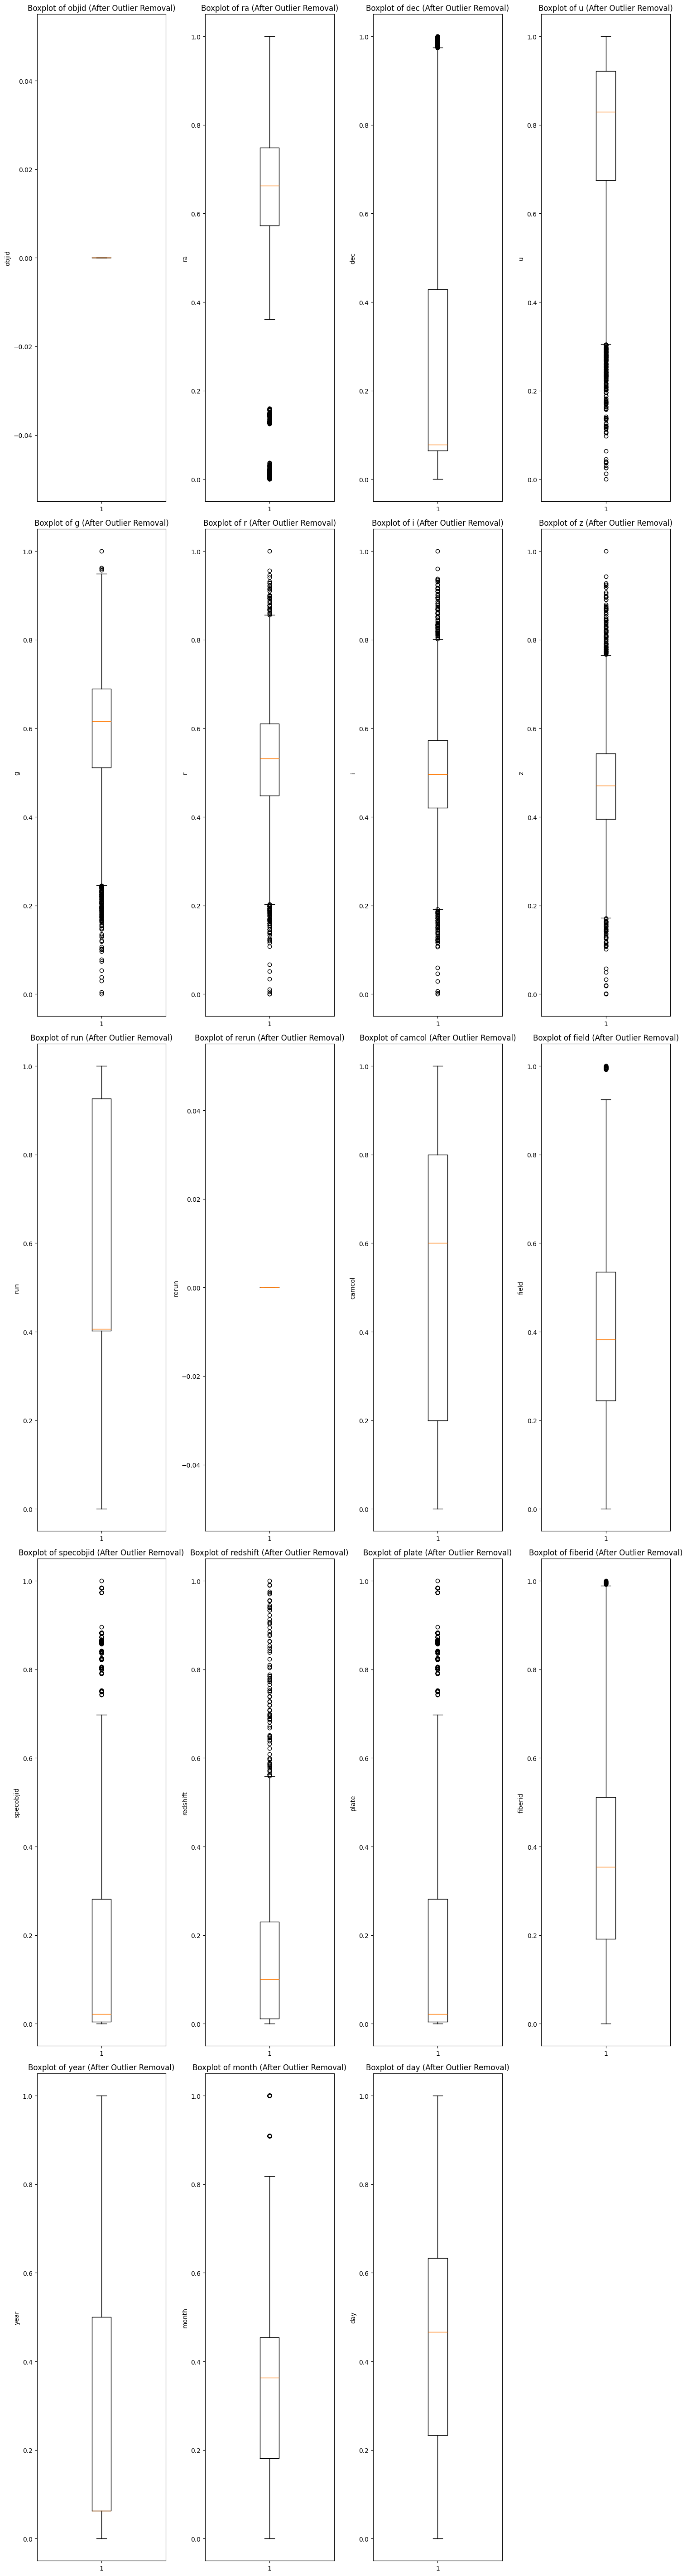

In [204]:
import matplotlib.pyplot as plt

# Plot the boxplots after outlier removal
plt.figure(figsize=(15, len(numeric_columns) * 3))
n_cols = 4  # Number of columns to fit multiple boxplots in one frame
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculate rows based on column count

# Generate a boxplot for each numeric column to verify outlier removal
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(space_data_no_outliers[col].dropna(), vert=True)  # Plot boxplot vertically
    plt.title(f'Boxplot of {col} (After Outlier Removal)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [205]:
# Split dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [206]:
# Standardize the features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Step 2**

In [207]:
# --- Step 2: Classification using Random Forest and Decision Tree ---
print("Running Random Forest and Decision Tree Classification for Space Objects...")

Running Random Forest and Decision Tree Classification for Space Objects...


In [208]:
X_train.shape
y_train.shape

(8000,)

In [209]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf_class = rf_clf.predict(X_test)


In [210]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt_class = dt_clf.predict(X_test)

In [211]:
# Classification Evaluation
print("Random Forest Classification Accuracy:", accuracy_score(y_test, y_pred_rf_class))
print("Decision Tree Classification Accuracy:", accuracy_score(y_test, y_pred_dt_class))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_class))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt_class))

Random Forest Classification Accuracy: 0.924
Decision Tree Classification Accuracy: 0.9005
Random Forest Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.92      0.94      0.93      1000
         QSO       0.92      0.88      0.90       170
        STAR       0.93      0.91      0.92       830

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Decision Tree Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.92      0.91      0.92      1000
         QSO       0.81      0.82      0.82       170
        STAR       0.89      0.90      0.90       830

    accuracy                           0.90      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.90      0.90      0.90      2000



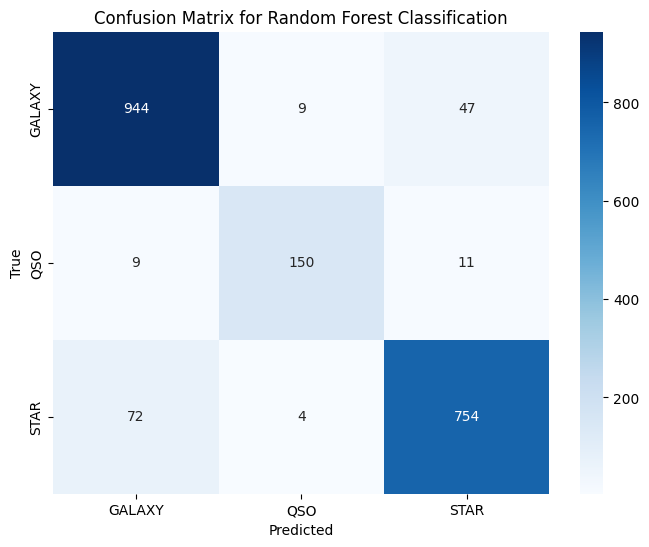

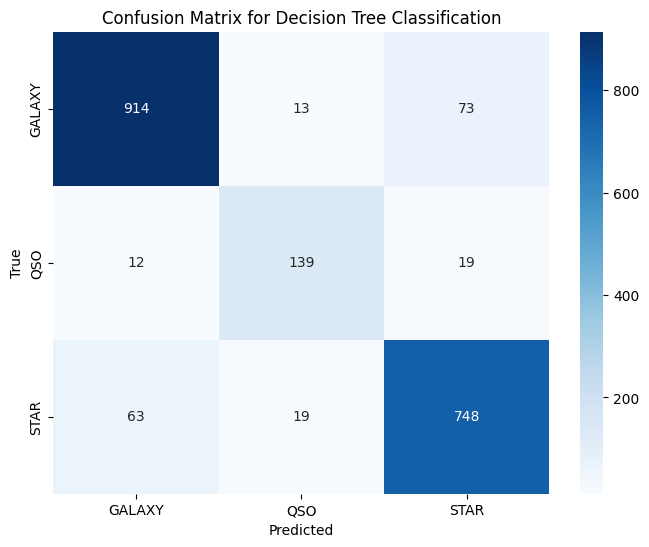

In [212]:
# --- Visualization: Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred_rf_class, 'Confusion Matrix for Random Forest Classification')
plot_confusion_matrix(y_test, y_pred_dt_class, 'Confusion Matrix for Decision Tree Classification')


**Step 3**

In [213]:
# --- Step 3: Regression for Orbit Prediction ---
print("\nRunning Random Forest and Decision Tree Regression for Orbit Prediction...")


Running Random Forest and Decision Tree Regression for Orbit Prediction...


In [214]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_scaled, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_scaled)

In [215]:
# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_scaled, y_train_reg)
y_pred_dt_reg = dt_reg.predict(X_test_scaled)

In [216]:
# Regression Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg))
rmse_dt = np.sqrt(mean_squared_error(y_test_reg, y_pred_dt_reg))
print(f"Random Forest Regression RMSE: {rmse_rf}")
print(f"Decision Tree Regression RMSE: {rmse_dt}")

Random Forest Regression RMSE: 0.4257539379046416
Decision Tree Regression RMSE: 0.5884760647649344


In [217]:
# --- Visualization: Regression Scatter Plot ---
def plot_regression_scatter(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', lw=2)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.xlim([min(y_true), max(y_true)])
    plt.ylim([min(y_true), max(y_true)])
    plt.grid(True)
    plt.show()


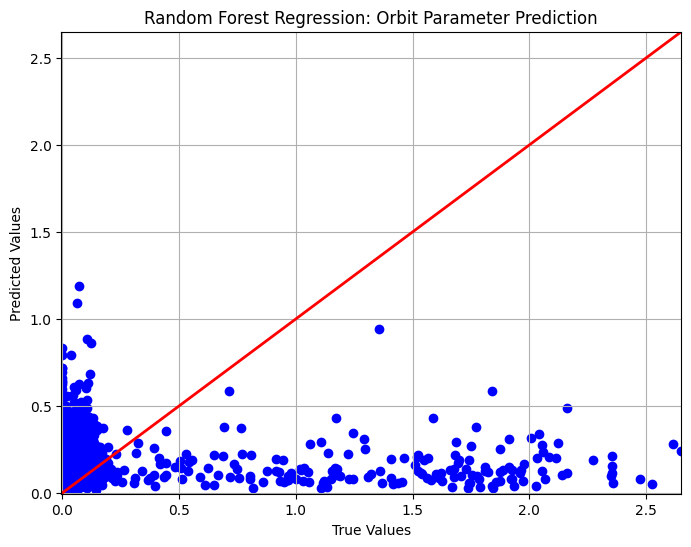

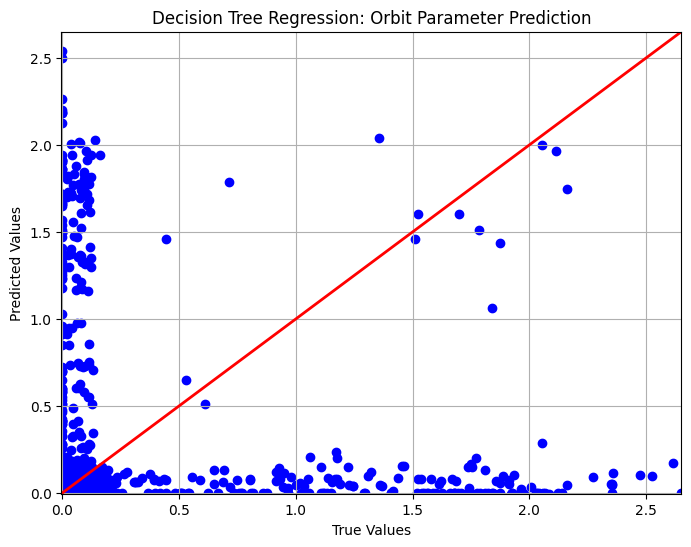

In [218]:
plot_regression_scatter(y_test_reg, y_pred_rf_reg, 'Random Forest Regression: Orbit Parameter Prediction')
plot_regression_scatter(y_test_reg, y_pred_dt_reg, 'Decision Tree Regression: Orbit Parameter Prediction')

**Step 4**

In [219]:
# --- Step 4: Cosine Similarity for Space Object Similarity ---
print("\nCalculating Cosine Similarity between Space Objects...")
cosine_sim = cosine_similarity(X)



Calculating Cosine Similarity between Space Objects...


In [220]:
# Example: Find the most similar objects to the first one
similar_objects = cosine_sim[0]
print("Cosine Similarities of object 0 with other space objects:\n", similar_objects)

Cosine Similarities of object 0 with other space objects:
 [1.         0.570319   0.5450792  ... 0.98531354 0.64974759 0.64974812]


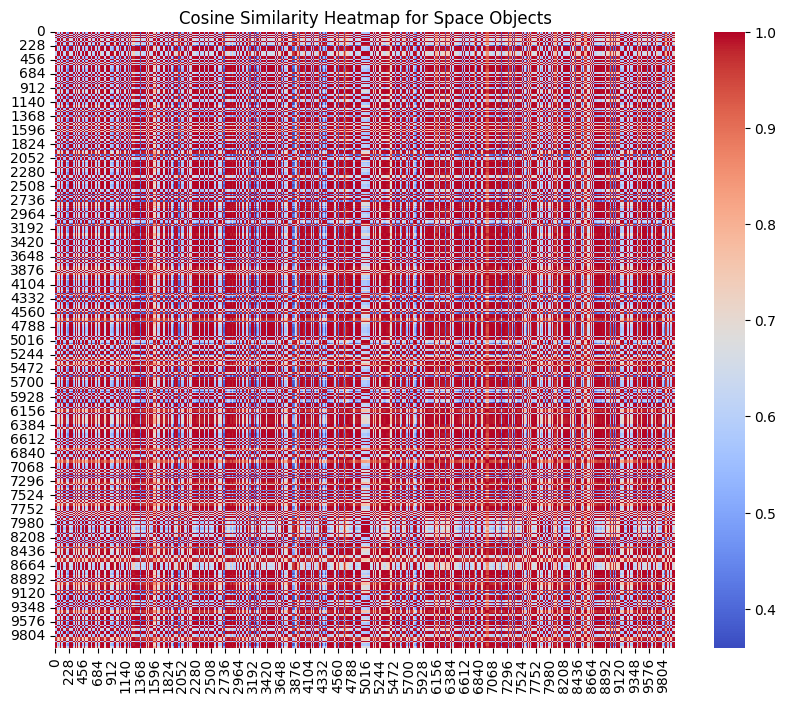

In [ ]:
# --- Visualization: Cosine Similarity Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, cmap='coolwarm')
plt.title('Cosine Similarity Heatmap for Space Objects')
plt.show()

**Step 5**

In [221]:
# --- Step 5: Feature Importance for Classification ---
print("\nRandom Forest Feature Importance for Classification...")
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]


Random Forest Feature Importance for Classification...


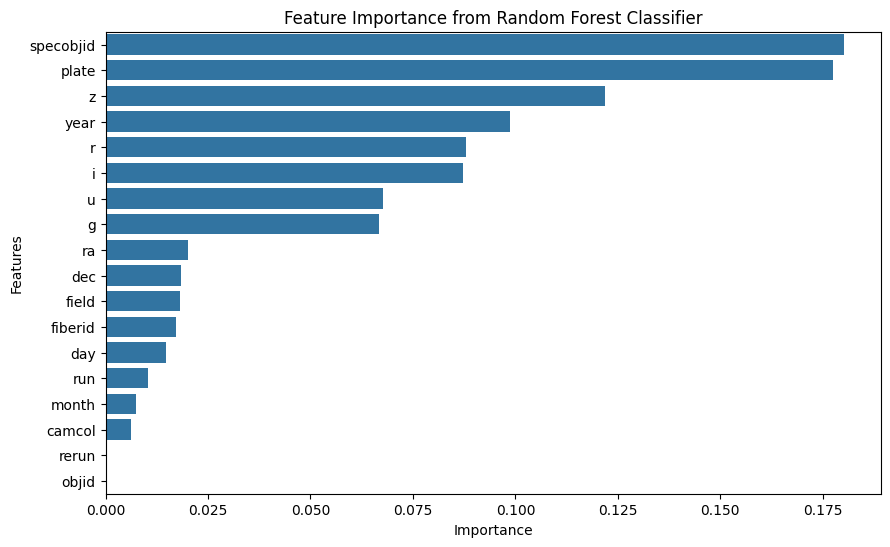

In [222]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importance from Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

**Step 6**

In [223]:
# --- Step 6: PCA for Dimensionality Reduction ---
print("\nRunning PCA for Dimensionality Reduction...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


Running PCA for Dimensionality Reduction...


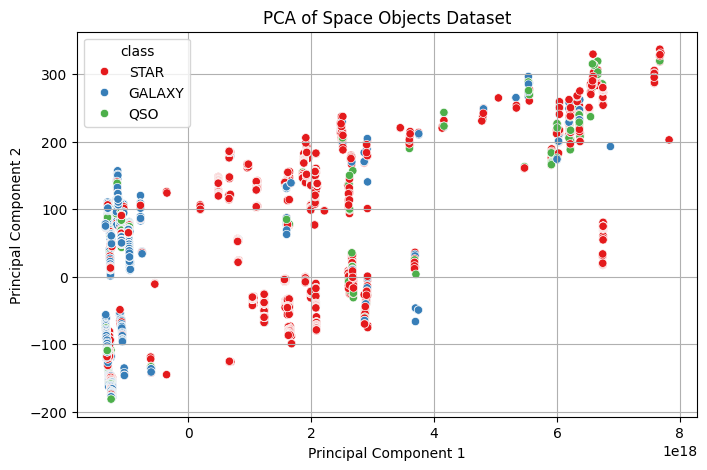

In [224]:
# Visualize PCA reduced data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=space_data[object_type_column], palette='Set1')
plt.title('PCA of Space Objects Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

**Step 7**

In [225]:
# --- Step 7: Clustering using K-Means ---
print("\nRunning K-Means Clustering on Space Objects...")
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)


Running K-Means Clustering on Space Objects...


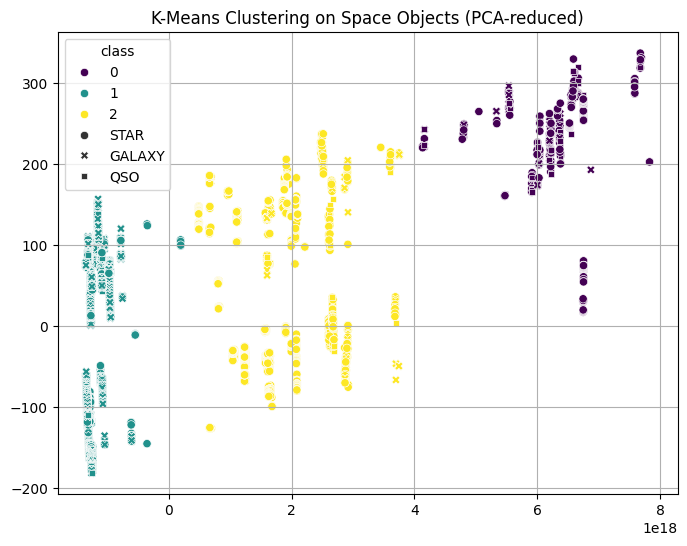

In [226]:
# Visualization of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_kmeans, palette='viridis', style=space_data[object_type_column])
plt.title('K-Means Clustering on Space Objects (PCA-reduced)')
plt.grid(True)
plt.show()

**Step 8**

In [227]:
# --- Step 8: Naive Bayes Classifier ---
print("\nRunning Naive Bayes Classification for Space Objects...")
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
y_pred_nb_class = nb_clf.predict(X_test)



Running Naive Bayes Classification for Space Objects...


In [231]:
# Naive Bayes Classification Evaluation
print("Naive Bayes Classification Accuracy:", accuracy_score(y_test, y_pred_nb_class))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb_class))


Naive Bayes Classification Accuracy: 0.7875
Naive Bayes Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.73      0.96      0.83      1000
         QSO       0.00      0.00      0.00       170
        STAR       0.91      0.73      0.81       830

    accuracy                           0.79      2000
   macro avg       0.54      0.57      0.55      2000
weighted avg       0.74      0.79      0.75      2000



**Step 9**

In [233]:
#  # --- Step 9: Future Predictions ---
# print("\nPredicting Future Orbits for Next 10 Days...")
# future_dates = pd.date_range(start='2025-01-01', periods=10, freq='D')
# future_mjd = (future_dates - base_date).days  # Convert to MJD

In [234]:
# # Create a DataFrame for future predictions
# future_data = pd.DataFrame({'mjd': future_mjd})
# future_data.shape

(10, 1)

In [235]:
# # Randomly select other features for simplicity (you might want to refine this)
for col in X.columns[1:]:
    # future_data[col] = np.random.choice(X[col], size=len(future_data))

In [236]:
# # Ensure future_data has the same columns as X_train before scaling
# # Drop 'mjd' as it was not part of the features used in training
# future_data_prepared = future_data.drop('mjd', axis=1)

In [237]:
# # # Standardize future data
# scaler = StandardScaler()
# future_data_scaled = scaler.fit_transform(future_data_prepared)

In [238]:
# future_data_scaled.shape
# y_train_reg.shape

(8000,)

In [241]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Assuming `X_train` and `y_train_reg` are already defined
# X_train: Feature matrix for training
# y_train_reg: Target variable for training (i.e., the orbits you're predicting)

# Step 1: Define the base date
base_date = pd.to_datetime('2024-11-01')  # Assuming base date is 1st Nov 2024

# Step 2: Generate the future dates
print("\nPredicting Future Orbits for Next 10 Days...")
future_dates = pd.date_range(start='2025-01-01', periods=10, freq='D')
future_mjd = (future_dates - base_date).days  # Convert to Modified Julian Date (MJD)

# Step 3: Create a DataFrame for the future predictions
future_data = pd.DataFrame({'mjd': future_mjd})

# Step 4: Ensure future_data has the same columns as X_train (including all features)
for col in X_train.columns[1:]:  # Exclude 'mjd' which is the first column (or temporal feature)
    future_data[col] = np.random.choice(X_train[col], size=len(future_data))

# Step 5: Ensure the future data has the same columns as the training data
# You might have to explicitly include missing features (for instance, features like "mjd")
for col in X_train.columns:
    if col not in future_data.columns:
        future_data[col] = np.random.choice(X_train[col], size=len(future_data))

# Step 6: Drop 'mjd' as it is not part of the model's features
future_data_prepared = future_data.drop('mjd', axis=1)

# Step 7: Standardize the future data using the same scaler as used for training
scaler = StandardScaler()
future_data_scaled = scaler.fit_transform(future_data_prepared)

# Step 8: Train the model (if not already trained)
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train_reg)

# Step 9: Predict future orbits
future_orbit_preds = rf_reg.predict(future_data_scaled)

# Step 10: Print the predictions
print("Future Orbit Predictions for Next 10 Days:")
print(future_orbit_preds)

# Step 11: Get indexes where predictions are greater than 0.9
indexes_above_0_9 = [i for i, value in enumerate(future_orbit_preds) if value > 0.9]

# Step 12: Print the indexes where the predicted value is greater than 0.9
print("\nIndexes where predicted value > 0.9:")
print(indexes_above_0_9)
print(len(indexes_above_0_9))



Predicting Future Orbits for Next 10 Days...
Future Orbit Predictions for Next 10 Days:
[0.86862279 0.90788909 0.94757656 0.93134139 0.91007614 0.94396119
 0.93134139 0.93061482 0.93061482 0.94271682]

Indexes where predicted value > 0.9:
[1, 2, 3, 4, 5, 6, 7, 8, 9]
9
